## Practical session 2. Nucleotide substitution & MCMC


In [2]:
import numpy as np # numpy is the standard numeric libray
import scipy.stats as ss # scipy is the scientific library, the stats module contains different functions
import matplotlib.pyplot as plt # matplotlib is the standard plotting library
import seaborn as sns # library for statistical plotting
import pymc as pm # library for Bayesian MCMC inference
import arviz as az # library to analyze and plot Bayesian results
import pandas as pd


In this practical we want to infer different substitution rates by comparing two different DNA sequences. The data that we will be using is the 12S rRNA alignment of human and orangutan. The output of the alignment is the count of different nucleotides which consists of 948 base pairs (Genbank accesion numbers for the human and orangutan sequences are D38112 and NC_001646, respectively (Horai et al. (1995)).):

In [3]:
data_df = pd.read_csv('orangutan_human.csv',index_col = 0)
display(data_df)

length = np.sum(data_df['A_human']+data_df['C_human']+data_df['G_human']+data_df['T_human'])

N_TC = data_df.loc['C_orangutan']['T_human'] + data_df.loc['T_orangutan']['C_human'] # transitions_TC
N_AG = data_df.loc['G_orangutan']['A_human'] + data_df.loc['A_orangutan']['G_human'] # transitions_AG

N_TA = data_df.loc['T_orangutan']['A_human'] + data_df.loc['A_orangutan']['T_human'] # transversion_TA
N_TG = data_df.loc['T_orangutan']['G_human'] + data_df.loc['T_orangutan']['G_human'] # transversion_TG
N_CG = data_df.loc['G_orangutan']['C_human'] + data_df.loc['C_orangutan']['G_human'] # transversion_CG
N_CA = data_df.loc['C_orangutan']['A_human'] + data_df.loc['A_orangutan']['C_human'] # transversion_CG


N_transition = N_TC+N_AG
N_transversion = N_TA+N_CG+N_CG+N_CA
N_intact = length - N_transition - N_transversion

print("Sequence length = ", length)
print("Number of transitionss = ",N_transition)
print("Number of transversions = ",N_transversion)

,T_human,C_human,A_human,G_human
T_orangutan,179,23,1,0
C_orangutan,30,219,2,0
A_orangutan,2,1,291,10
G_orangutan,0,0,21,169


Sequence length =  948
Number of transitionss =  84
Number of transversions =  6


There are in total 90 base differences between both mitochondrial 12s RNAs. From this substitutions we have 84 transitions (i.e. ($T\!\iff\!C$) and ($A\!\iff\!G$)), and 6 transversions (rest of substitutions). In Kimura’s 1980 (K80) nucleotide substitution model that has two parameters:

1) The sequence distance $d$ between species. $d=rt$ is the product of the average mutation rate $f$ and the branch length $t$. Since the time difference is usually unknown (unless there are fossil calibrations), one canot differentiate between a fast mutation rate over a long time, agains a slow mutation over a long time. On the contrary the distance $d=rt$ controlling the number of mutations that occured can be inferred when comparing two sequences.

 2) The transition/transversion rate ratio ($\kappa$ = rate_transition/rate_transversion) which accounts for the fact that transitions often occur at higher rates than transversions ($\kappa\gg 1$).

We need to write a function that returns us the log-likelihood given the distance between two sequences ($d$) and the ratio ($\kappa$), which can written as $P(data|d,\kappa)$. The process is a Markovian, and following similar arguments to the ones we saw on the probability theory session we know the probability distribution for each site after a time t is:

- Probability of a site staying the same:
$P_{intact} = \frac{1}{4} + \frac{1}{4}e^{-8d/(k+2)} + \frac{1}{2}e^{-4d\frac{k+1}{k+2}}$
- Probability of a site showing a translation:
$P_{transition} = \frac{1}{4} + \frac{1}{4}e^{-8d/(k+2)} - \frac{1}{2}e^{-4d\frac{k+1}{k+2}}$
- Probability of a site showing a transcription:
$P_{transversion} = \frac{1}{2} - \frac{1}{2}e^{-8d/(k+2)}$

The resulting likelihood for our observation is the multinomial distribution (similar to the binomial but with more than 2 possible types of results):

In [33]:
def P_intact(k,d):
    return 0.25 + 0.25*np.exp(-8*d/(k+2)) + 0.5*np.exp(-4*d*(k+1)/(k+2))
def P_transition(k,d):
    return 0.25 + 0.25*np.exp(-8*d/(k+2)) - 0.5*np.exp(-4*d*(k+1)/(k+2))
def P_transversion(k,d):
    return 0.5 - 0.5*np.exp(-8*d/(k+2))

def log_likelihood(k,d): # this corresponds to a multinomial, check it!
    return N_intact*np.log(P_intact(k,d))+N_transition*np.log(P_transition(k,d))+N_transversion*np.log(P_transversion(k,d)) 
# usually is easier numerically to work with log_likelihood than likelihoods since they can be really small
    

**Q1.1** Check that the probabilities of finding a nucleotide intact or mutating make sense by plotting the three probability components $P_j(k)$ for different values of $d$, and exploring the limit cases of $d$, $k$. 

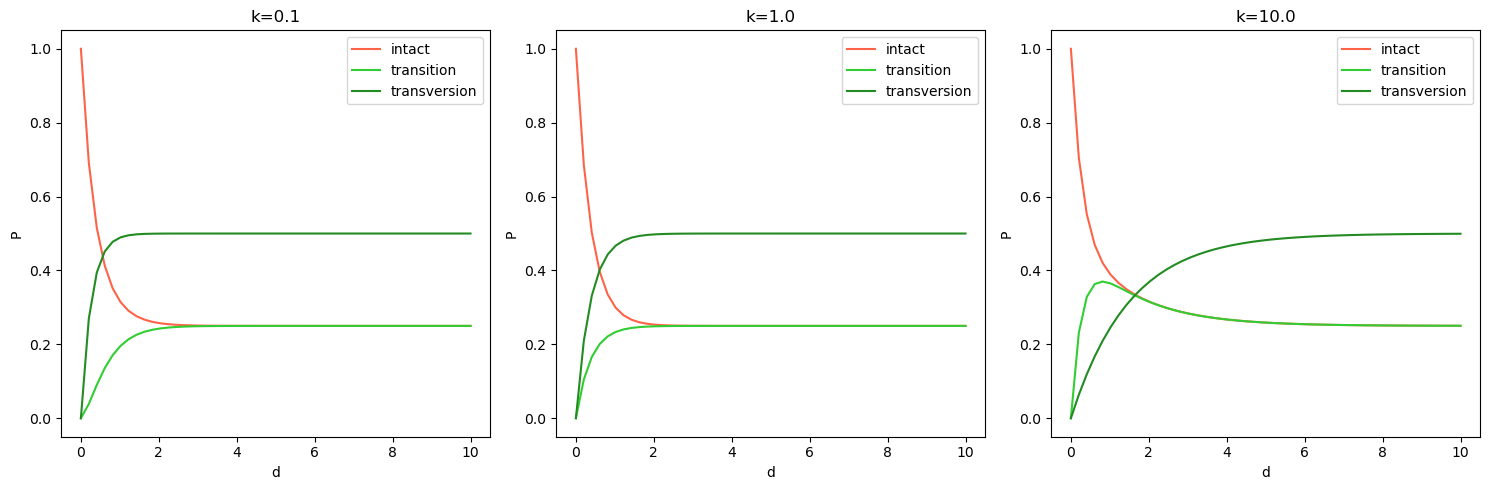

In [32]:
ks = [0.1,1.0,10.0]
fig, ax = plt.subplots(1,len(ks),figsize = [15,5])
for ik,k in enumerate(ks): 
    d = np.linspace(0,10)
    ax[ik].plot(d,P_intact(k,d),'-',c = 'tomato',label = 'intact')
    ax[ik].plot(d,P_transition(k,d), c = 'limegreen',label = 'transition')
    ax[ik].plot(d,P_transversion(k,d), c = 'forestgreen',label = 'transversion')
    ax[ik].set_title('k={}'.format(k))
    ax[ik].set_xlabel('d')
    ax[ik].set_ylabel('P')
    ax[ik].legend()
plt.tight_layout()    
    

**Q1.2 Brute force inference** If we want to obtain the posterior distribution $P(k,d|data)$ we need to evaluate the distributions at *all* possible values of $k$ and $d$. Since this is impossible we could also run MCMC to sample $P(k,d|data)$ in a smart way. A more rudimentary alternative is to divide the parameter space (k,d) into a grid and evaluate the posterior for those values.

/var/folders/jn/t3c3sdmd16n9_bpcqqn5pmb80000gp/T/ipykernel_26763/1672781822.py:9: RuntimeWarning: divide by zero encountered in log
  return N_intact*np.log(P_intact(k,d))+N_transition*np.log(P_transition(k,d))+N_transversion*np.log(P_transversion(k,d))


Text(0, 0.5, 'd')

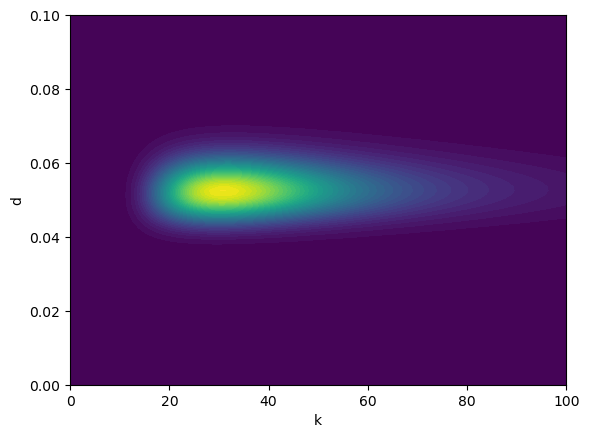

In [48]:

# First you need to find a limit for your prior that make sense, it should be hard to find them by eye,
# but you can evaluate the likelihood at different values of k,d to have an idea of the ranges
min_k = 0 
max_k = 100
min_d = 0
max_d = 0.1

k_range = np.linspace(min_k,max_k,100)
d_range = np.linspace(min_d,max_d,100)
K,D = np.meshgrid(k_range,d_range)

posterior = np.exp(log_likelihood(K,D))

plt.contourf(k_range, d_range, posterior, levels=50, cmap='viridis')  # Contour plot
plt.xlabel('k')
plt.ylabel('d')



**Q1.3 MCMC**. We can also infer the parameters running an implemented MCMC

In [38]:
with pm.Model() as Pea_Model:
    k_prior = pm.Uniform('k',0,100)### Define the prior disrtibution using a Truncated Normal. the prior could also use a uniform distribution, play with different values to see how it affects the result!
    d_prior = pm.Uniform('d',0,0.1)
    
    # we need to define out custom likelihood
    def log_likelihood_name(name,k,d):
        return log_likelihood(k,d)
    
    f_likelihood = pm.Potential("likelihood",log_likelihood_name('ll',k_prior,d_prior))
    mcmc_sample = pm.sample(4000, chains = 2, return_inferencedata = True)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [k, d]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


/Users/rperezca/miniconda/envs/pymc4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rperezca/miniconda/envs/pymc4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/jn/t3c3sdmd16n9_bpcqqn5pmb80000gp/T/ipykernel_26763/1429446573.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.gca().set_facecolor(plt.cm.get_cmap('viridis')(0))


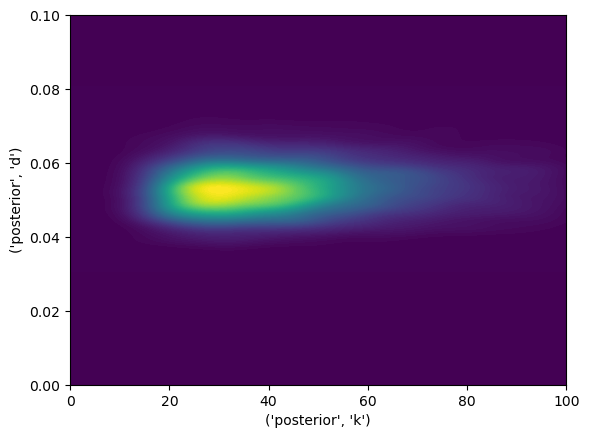

In [45]:
az.summary(mcmc_sample) # summary of MCMC statistics
posterior = mcmc_sample.to_dataframe()
sns.kdeplot(posterior,x=('posterior', 'k'),y=('posterior', 'd'),
            cmap=plt.cm.viridis,fill=True,thresh=0,levels = 100)
plt.xlim([0,100])
plt.ylim([0,0.1])
plt.gca().set_facecolor(plt.cm.get_cmap('viridis')(0))

**Q1.4 Just for the braves** Code an MCMC yourself. You can follow the steps of the algorithm we discussed in class. You will have freedom on the choices of the proposal step (take into account the different lengthscales in k and d). Make sure to analyze the trace to evaluate if your results has converged. 

Rejected point
Rejected point
Rejected point
Rejected point
Accepted point: 1/4000
Rejected point
Rejected point
Rejected point
Accepted point: 2/4000
Rejected point
Accepted point: 3/4000
Rejected point
Rejected point
Accepted point: 4/4000
Accepted point: 5/4000
Rejected point
Rejected point
Accepted point: 6/4000
Accepted point: 7/4000
Accepted point: 8/4000
Rejected point
Rejected point
Rejected point
Accepted point: 9/4000
Accepted point: 10/4000
Accepted point: 11/4000
Accepted point: 12/4000
Accepted point: 13/4000
Rejected point
Rejected point
Accepted point: 14/4000
Rejected point
Accepted point: 15/4000
Rejected point
Accepted point: 16/4000
Rejected point
Accepted point: 17/4000
Accepted point: 18/4000
Accepted point: 19/4000
Rejected point
Accepted point: 20/4000
Accepted point: 21/4000
Accepted point: 22/4000
Rejected point
Accepted point: 23/4000
Accepted point: 24/4000
Accepted point: 25/4000
Rejected point
Accepted point: 26/4000
Accepted point: 27/4000
Rejected point
A

/var/folders/jn/t3c3sdmd16n9_bpcqqn5pmb80000gp/T/ipykernel_26763/1672781822.py:9: RuntimeWarning: invalid value encountered in log
  return N_intact*np.log(P_intact(k,d))+N_transition*np.log(P_transition(k,d))+N_transversion*np.log(P_transversion(k,d))
/Users/rperezca/miniconda/envs/pymc4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rperezca/miniconda/envs/pymc4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/jn/t3c3sdmd16n9_bpcqqn5pmb80000gp/T/ipykernel_26763/4230399726.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and

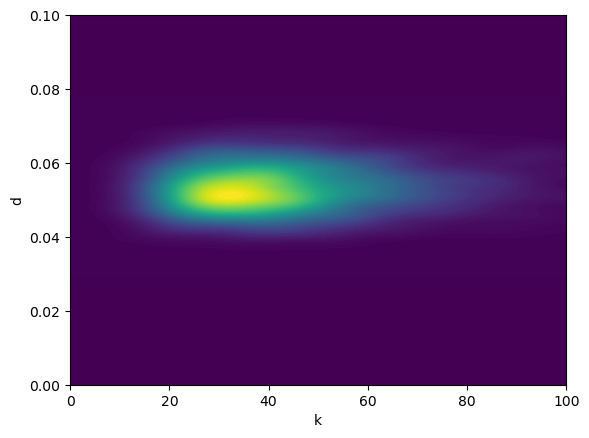

In [58]:
accepted_points = []
N_points = 4000
last_point = np.array([40,0.05])
last_posterior = np.exp(log_likelihood(last_point[0],last_point[1])) 


while(len(accepted_points)<N_points):
    proposed_jump = [np.random.normal(0,10),np.random.normal(0,0.01)]
    proposed_point = last_point + np.array(proposed_jump)
    new_posterior = np.exp(log_likelihood(proposed_point[0],proposed_point[1])) 
    r = new_posterior/last_posterior
    if r>1 or r>np.random.random():
        accepted_points.append(proposed_point)
        last_point = proposed_point
        last_posterior = new_posterior
        print("Accepted point: {}/{}".format(len(accepted_points),N_points))
    else:
        print("Rejected point")

trace = pd.DataFrame(accepted_points,columns=['k','d'])

sns.kdeplot(trace,x='k',y='d',
            cmap=plt.cm.viridis,fill=True,thresh=0,levels = 100)
plt.xlim([0,100])
plt.ylim([0,0.1])
plt.gca().set_facecolor(plt.cm.get_cmap('viridis')(0))
    